In [1]:
from models import *
import models as m
from utils import * 
from visualize import *
from dataset import *
import random
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import normalized_mutual_info_score as mis
import numpy as np
from training import *

## Initialize dataset

In [2]:
data_name = "Corr" #"Corr" Mutagenicity" #'IMDB-BINARY' 'MUTAG'

In [3]:
if data_name == "Corr":
    parameters = {'n_nodes' : 30, 'noise_std' : 0.5, 'len_sig' : 100, 'phase_std' : np.pi/10, 'n_active_nodes' : 6}
    active_nodes = [1,2,3,4,14,15,16,27,28,29]
    dataset = CorrDataset(parameters, active_nodes, 200).dataset
else:    
    dataset = TUDataset(root='data/TUDataset', name=data_name)
    
    print()
    print(f'Dataset: {dataset}:')
    print('====================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

In [4]:
dataset = [data for data in dataset if data.x.shape[0] < 40]

In [5]:
max_n_nodes = get_max_n_nodes(dataset)
print(f'Max number of nodes: {max_n_nodes}')

Max number of nodes: 30


In [6]:
dataset = add_edge_noise(dataset, 0, 10)

In [7]:
dataset = update_dataset(dataset, max_n_nodes)

In [8]:
torch.manual_seed(12345)
random.shuffle(dataset)

train_dataset = dataset[:3*len(dataset)//4]
test_dataset = dataset[3*len(dataset)//4:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 50


In [9]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Example of a graph in the dataset:


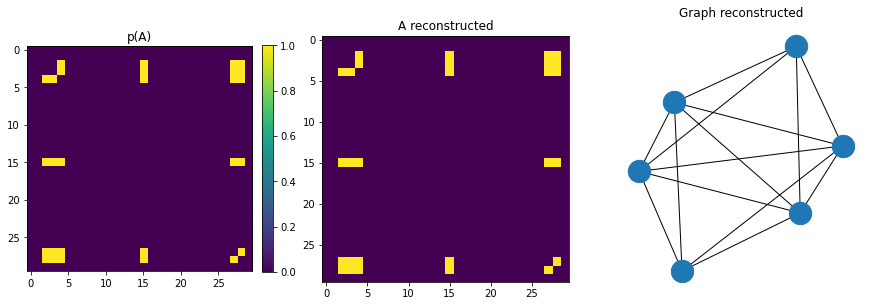

In [10]:
print('Example of a graph in the dataset:')
visualize_adj_graph(dataset[0].adj.squeeze())

Example of a graph in the dataset:


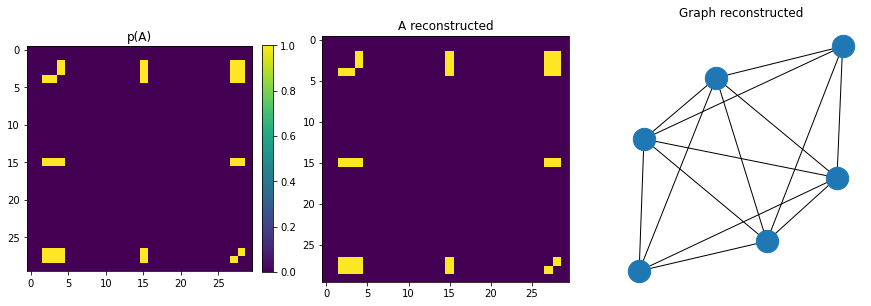

In [11]:
print('Example of a graph in the dataset:')
visualize_adj_graph(dataset[0].adj.squeeze())

## Initialize & train a model

In [20]:
latent_dim = 11

n_nodes = max_n_nodes
feat_dim = dataset[0].x.shape[1]
edge_dim = 0 #dataset[0].edge_attr.shape[1]
hidden_dim_ = 64 # adjMLP
hidden_dim = 16 # GNN
beta = 1.
gamma = 0.
delta = 0.
dropout = 0.0
lr = 1e-3
epochs = 200
save_file = None
model_type = 'conv_mlp'

#prior = torch.distributions.normal.Normal(0, 1)
prior = torch.distributions.laplace.Laplace(0, 1.)

In [21]:
encoder_ = getattr(m, 'Encoder_{}'.format(model_type))
encoder = encoder_(n_nodes, feat_dim, hidden_dim, latent_dim, dropout)
decoder = Decoder(n_nodes, latent_dim, hidden_dim, dropout)
model = VAE(encoder, decoder, prior, beta, gamma)    
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
log = fit(model, optimizer, train_loader, test_loader, epochs, save_file)

Training for 200 epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 11.00it/s]

Optimization Finished!
Model type: conv_mlp
Best epoch: 196 , Best test set loss: 48.8756
Sparseness: 0.244
Cov: 0.048


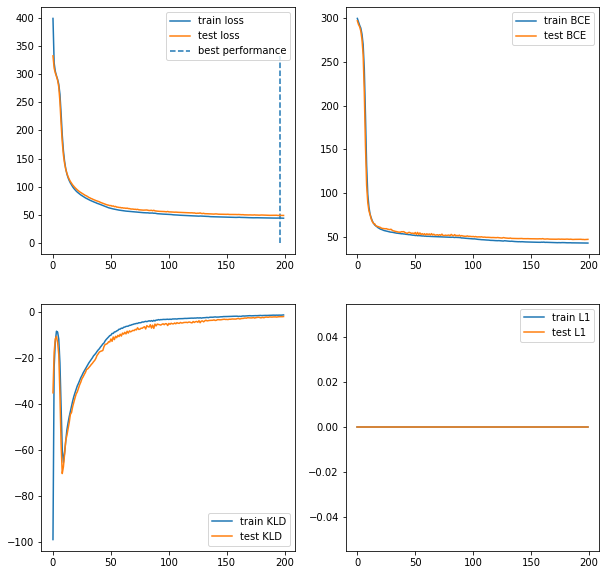

In [23]:
performance_plot(log)

## Visualize results

In [15]:
model.state_dict = torch.load('model')
model.deterministic = True

In [17]:
# get random graph as Data object
data = random.choice(list(train_loader))
# the Data object is a batch => take a random index from the batch
n = random.choice(range(len(data.y)))
if model.type == 'mp':
    recovered, mu, logvar, z = model(data.x, data.edge_index, data.edge_attr, data.u, data.batch)
elif model.type == 'adj':
    recovered, mu, logvar, z = model(data.adj.view(-1, model.n_nodes**2))
else:
    recovered, p1, p2, z = model(x = data.x, edge_index = data.edge_index, batch = data.batch, edge_weight = None)  
    
adj_pred = tensor_from_trian(recovered)[n].detach().numpy()
adj = data.adj[n].detach().numpy()
#adj_clear = data.adj_[n].detach().numpy() + adj

visualize_recon_adj(adj_pred, adj, 0.5, None) #adj_clear)

#visualize_recon_graph(adj_pred, adj_clear, 0.5)

TypeError: forward() got an unexpected keyword argument 'x'

## Latent space (2D case)

No handles with labels found to put in legend.


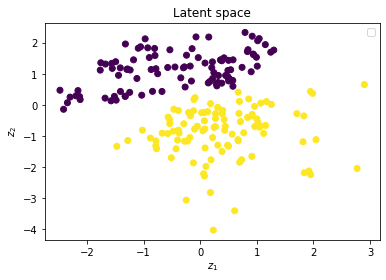

In [19]:
if model.latent_dim == 2:
    model.state_dict = torch.load('model')
    all_loader = DataLoader(dataset, batch_size=10**10, shuffle=True)
    data = next(iter(all_loader))
    if model.type == 'mp':
        recovered, mu, logvar, z = model(data.x, data.edge_index, data.edge_attr, data.u, data.batch)
    elif model.type == 'adj':
        recovered, mu, logvar, z = model(data.adj.view(-1, model.n_nodes**2))
    else: 
        recovered, mu, logvar, z = model(data.x, data.edge_index, data.batch)          
    z = model.reparameterize(mu, logvar).detach().numpy()
    
    visualize_z_space(z, data.y)

## Inference task I: $argmax_{A}p(A|y)$ 

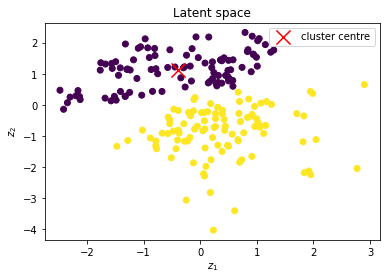

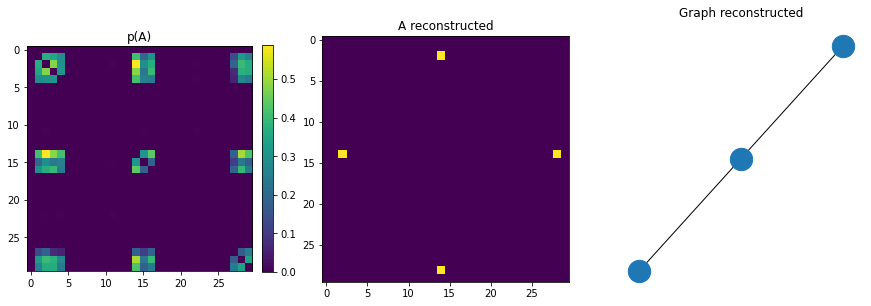

In [25]:
y = 0

mask = create_mask(n_nodes)
z_y = get_cluster(model, dataset, y)
z_centre = cluster_centre(z_y)

if model.latent_dim == 2:
    visualize_z_space(z, data.y, z_centre.detach().numpy())
    
a_y = model.decoder(z_centre).unsqueeze(0)
a_y = tensor_from_trian(a_y)

a_y.view(model.n_nodes,model.n_nodes)
a_y = (a_y*mask).detach().numpy().squeeze()

visualize_adj_graph(a_y)

## Inference task II: $argmax_{z_i \in Z} MI(z_i, Y)$ 

In [71]:
loader = DataLoader(dataset, batch_size=10**10, shuffle=True)

In [72]:
data = next(iter(loader))

In [76]:
data.adj.shape

torch.Size([188, 28, 28])

In [77]:
if model.type == 'adj':
    mu, logvar = model.encode(data.adj.view(-1,784))
else:
    mu, logvar = model.encode(data.x, data.edge_index, data.batch)
z = model.reparameterize(mu, logvar).detach()

In [ ]:
cs = np.abs(cosine_similarity(z.T)).mean()
print('Average cosine similarity between latent variables: {:.2f}'.format(cs))

In [ ]:
vis_digitized(z[:,0], digitize_z(z[:,0]))

In [ ]:
# compute MI(z_i, Y) for each z_i in Z
mi = []
for i in range(hidden2):
    a = digitize_z(z[:,i])
    b = data.y.detach().numpy()
    mi.append(mis(a,b))

In [ ]:
plt.bar(x = range(len(mi)), height = mi)
plt.xlabel('$z_i$')
plt.ylabel('MI($z_i$, Y)')
plt.title('MI($z_i$, Y)')

In [ ]:
# range of z_i with max MIS
a = z[:,np.argmax(mi)].min()
b = z[:,np.argmax(mi)].max()

In [ ]:
# Vary z_i across its range and see how adajcency matrix changes
for value in np.arange(a, b, (b-a)/10):
    z = torch.zeros(hidden2)
    z[i] = value
    adj = ((model.decode(z).view(28,28)*mask).detach().numpy() > 0.5)*1
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(adj.squeeze())
    show_graphs(adj.squeeze(), ax = ax2)

In [17]:
from torch_geometric.nn import MetaLayer

In [16]:
data = next(iter(train_loader))

In [19]:
op = MetaLayer(EdgeModel(19, 10, 2), NodeModel(9, 10, 2), GlobalModel(2, 10, 2))
x, edge_attr, u = op(data.x, data.edge_index, data.edge_attr, data.u, data.batch)